In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!tar -zxvf  "/content/drive/My Drive/Colab Notebooks/concrete_detection_image.tar.gz"

concrete_detection_image/2013crack-002_travel_5.jpg
tar: concrete_detection_image/2013crack-002_travel_5.jpg: time stamp 2020-11-06 10:31:03 is 19568.82094988 s in the future
concrete_detection_image/2012crack-002_travel_2.jpg
tar: concrete_detection_image/2012crack-002_travel_2.jpg: time stamp 2020-11-06 10:31:05 is 19570.813117275 s in the future
concrete_detection_image/2012crack-002_travel_all3.xml
tar: concrete_detection_image/2012crack-002_travel_all3.xml: time stamp 2020-11-06 10:31:06 is 19571.812991376 s in the future
concrete_detection_image/2014crack-002_travel_all3.xml
tar: concrete_detection_image/2014crack-002_travel_all3.xml: time stamp 2020-11-06 10:31:03 is 19568.812914813 s in the future
concrete_detection_image/2013crack-002_travel_all1.xml
tar: concrete_detection_image/2013crack-002_travel_all1.xml: time stamp 2020-11-06 10:31:03 is 19568.812839156 s in the future
concrete_detection_image/2013crack-002_travel_4.jpg
tar: concrete_detection_image/2013crack-002_travel_

In [22]:
import os
import shutil
import numpy as np
import pandas as pd
 
from PIL import Image
from glob import glob
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [23]:
class xml2list(object):
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path):
        
        ret = []
        xml = ET.parse(xml_path).getroot()
        
        for size in xml.iter("size"):     
            width = float(size.find("width").text)
            height = float(size.find("height").text)
                
        for obj in xml.iter("object"):
            difficult = int(obj.find("difficult").text)
            if difficult == 1:
                continue          
            bndbox = [width, height]        
            name = obj.find("name").text.lower().strip() 
            bbox = obj.find("bndbox")            
            pts = ["xmin", "ymin", "xmax", "ymax"]     
            for pt in pts:         
                cur_pixel =  float(bbox.find(pt).text)               
                bndbox.append(cur_pixel)           
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)    
            ret += [bndbox]
            
        return np.array(ret) # [width, height, xmin, ymin, xamx, ymax, label_idx]

Bounding Boxと画像, Labelを管理

In [24]:
df = pd.DataFrame(columns=["image_id", "width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
print(df)

Empty DataFrame
Columns: [image_id, width, height, xmin, ymin, xmax, ymax, class]
Index: []


In [25]:
# XMLファイルの列挙
xml_paths = glob("./concrete_detection_image/*.xml")
# クラスの定義
classes = ["concrete"]
# transform to array
transform_anno = xml2list(classes)

In [26]:
for path in xml_paths:
    image_id = path.split("/")[-1].split(".")[0]
    bboxs = transform_anno(path)
    
    for bbox in bboxs:
        tmp = pd.Series(bbox, index=["width", "height", "xmin", "ymin", "xmax", "ymax", "class"])
        tmp["image_id"] = image_id
        df = df.append(tmp, ignore_index=True)
print(df['class'].value_counts())

0.0    210
Name: class, dtype: int64


In [28]:
df = df.sort_values(by="image_id", ascending=True)

In [29]:
df["class"] = df["class"] + 1

データセットの作成
入力画像とアノテーションデータを読みこみ

In [30]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, image_dir):
        
        super().__init__()
        
        self.image_ids = df["image_id"].unique()
        self.df = df
        self.image_dir = image_dir
        
    def __getitem__(self, index):
        
        # Data Augumation
        transform = transforms.Compose([ transforms.ToTensor() ])
        
        # 入力画像の読み込み
        image_id = self.image_ids[index]
        image = Image.open(f"{self.image_dir}/{image_id}.jpg")
        # To Tensor
        image = transform(image)
        
        # アノテーションデータの読み込み
        records = self.df[self.df["image_id"] == image_id]
        boxes = torch.tensor(records[["xmin", "ymin", "xmax", "ymax"]].values, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        labels = torch.tensor(records["class"].values, dtype=torch.int64)
        
        iscrowd = torch.zeros((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"]= labels
        target["image_id"] = torch.tensor([index])
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return image, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

入力画像とアノテーションデータは./concrete-detection-imageに格納

In [31]:
image_dir = "./concrete_detection_image"
dataset = MyDataset(df, image_dir)

訓練データと検証データに分割し、データローダーを作成

In [32]:
torch.manual_seed(2020)
 
n_train = int(len(dataset) * 0.7)
n_val = len(dataset) - n_train
 
train, val = torch.utils.data.random_split(dataset, [n_train, n_val])
 
def collate_fn(batch):
    return tuple(zip(*batch))
 
train_dataloader = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, collate_fn=collate_fn)

dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

62
28


faster-R-CNNを用いたモデルを読み込み
ネットワークモデルを定義

In [34]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
num_classes = 2 # background, concrete
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


学習（cuda:0）
エポック数は5とし、訓練モードの時、損失関数計算と勾配、最適化、パラメータ更新など

In [76]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 10

if torch.cuda.is_available():
    model.cuda()
 
for epoch in range(num_epochs):
    
    model.train()
    
    for i, batch in enumerate(train_dataloader):
        
        images, targets, image_ids = batch
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        pred = model(images, targets)
        losses = sum(loss for loss in pred.values())
        loss_value = losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")  

cuda:0
tensor([2423172., 2555362.])
tensor([2671683., 2505536.])
tensor([ 624268.,  722036., 2347168., 2590301.])
tensor([2390850., 2633796.])
tensor([2540416., 2523331.])
tensor([2912304.])
tensor([2892510.])
tensor([2812768.,  461097.])
tensor([2938908.])
tensor([2524749., 2409443.])
tensor([2475672., 2606904.])
tensor([ 700768., 2566710.,  695952., 2519786.])
tensor([2650710., 2464106.])
tensor([2964504.])
tensor([2567952.,  603174.])
tensor([2513984., 2620160.])
tensor([2553972., 2419956.])
tensor([2944947.])
tensor([2643888., 2408400.])
tensor([2933440.])
tensor([ 701298., 2575440.,  674325., 2384252.])
tensor([2538280., 2435724.])
tensor([2549676., 2499000.])
tensor([2397260., 2543958.])
tensor([ 465818., 2844288.])
tensor([2699880., 2407994.])
tensor([2575064.,  610688.])
tensor([2612940.,  637120., 2492880.,  619332.])
tensor([ 636480., 2541318.])
tensor([2505594., 2619742.])
tensor([2400975., 2572528.])
tensor([2913422.])
tensor([2974878.])
tensor([ 637275., 2611440., 2552400.

推論
推論結果を./resultに格納されるようにフォルダ作成
検出して領域をくり抜いた部分を格納する./detectionを作成

In [80]:
image_dir_path = './result'
if not (os.path.exists(image_dir_path)):
        os.makedirs(image_dir_path)

画像からコンクリート部分を検出できているか確認

tensor([2521920., 2570400.])
tensor([ 690752., 2566200., 2407860.,  737325.])
tensor([ 736892., 2460976.,  616960., 2788450.])
tensor([2395880., 2533966.])
0 52 3512 793
0 880 3544 1591
17 852 3568 1607
22 78 3612 783
3604 861 4562 1598
3603 87 4552 799
1108 905 4579 1607
1008 45 4579 829
7 904 933 1612
0 25 952 827
0 834 3510 1575
0 75 3525 763


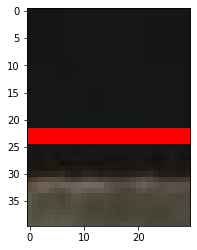

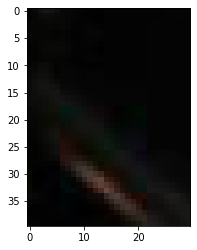

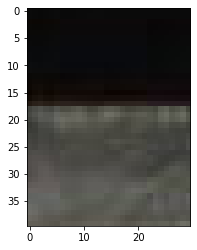

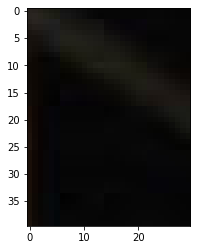

In [90]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)
model.eval()
 
images, targets, image_ids = next(iter(val_dataloader))
 
images = list(img.to(device) for img in images)
outputs = model(images)
 
for i, image in enumerate(images):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))
    
    boxes = outputs[i]["boxes"].data.cpu().numpy()
    scores = outputs[i]["scores"].data.cpu().numpy()
    labels = outputs[i]["labels"].data.cpu().numpy()
    
    category = {0: "background", 1: "concrete"}
    
    boxes = boxes[scores >= 0.5].astype(np.int32)
    scores = scores[scores >= 0.5]
    image_id = image_ids[i]
    
    for i, box in enumerate(boxes):

        draw = ImageDraw.Draw(image)
        label = category[labels[i]]
        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)
        left_x = box[0]
        left_y = box[1]
        right_x = box[2]
        right_y = box[3]
        print('%d %d %d %d'%(left_x, left_y, right_x, right_y))
        im = image.crop((left_x, left_y, right_x, right_y))
        #image.save(f'./detection/{str(image_id)}_{str(i)}.jpg')

        #fig, ax = plt.subplots(1, 1)
        #ax.imshow(np.array(im))

テスト用のデータローダーを作成

In [64]:
test = dataset
test_dataloader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [98]:
!rm -rf ./detection

In [99]:
detection_dir_path = './detection'
if not (os.path.exists(detection_dir_path)):
        os.makedirs(detection_dir_path)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)
model.eval()

for i, batch in enumerate(test_dataloader):
        
        images, targets, image_ids = batch
        images = list(img.to(device) for img in images)
        outputs = model(images)
      

        for i, image in enumerate(images):
          image = image.permute(1, 2, 0).cpu().numpy()
          h,w = image.shape[0], image.shape[1]
          image = Image.fromarray((image * 255).astype(np.uint8))
          
          boxes = outputs[i]["boxes"].data.cpu().numpy()
          scores = outputs[i]["scores"].data.cpu().numpy()
          labels = outputs[i]["labels"].data.cpu().numpy()
          
          category = {0: "background", 1: "concrete"}
          
          boxes = boxes[scores >= 0.5].astype(np.int32)
          scores = scores[scores >= 0.5]
          image_id = image_ids[i]

          with open(f'./result/{str(image_id)}.txt', mode='w') as file:
            for i, box in enumerate(boxes):

              # 検出部を赤い矩形図形で囲む
              draw = ImageDraw.Draw(image)
              label = category[labels[i]]
              # ((左上のx座標, 左上のy座標), (右下のx座標, 右下のy座標))
              draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

              # 検出部を切り抜き./detectionに格納
              # img = Image.open(image)
              left_x = box[0]
              left_y = box[1]
              right_x = box[2]
              right_y = box[3]
              im = image.crop(box=(left_x, left_y, right_x, right_y))
              im.save(f'./detection/{str(image_id)}_{str(i)}.jpg')

              # txtファイルの作成
              x_center = (left_x+right_x)/2
              y_center = (left_y+right_y)/2
              width = abs(right_x-left_x)
              height = abs(right_y-left_y)
              file.write('%d %f %f %f %f\n'%(labels[i]-1, box[0]/w, box[1]/h, box[2]/w, box[3]/h))
              print('%d %f %f %f %f'%(labels[i]-1, x_center/w, y_center/h, width/w, height/h))
          
          file.close()

          image.save(f'./result/{str(image_id)}.jpg')

tensor([2368636.,  664346., 2676000.,  727296.])
tensor([2647593., 2394580.])
tensor([2653996., 2413996.])
tensor([2563235., 2465001.])
0 0.606355 0.261818 0.787290 0.476364
0 0.622625 0.761212 0.754750 0.423030
0 0.102424 0.762121 0.202228 0.429697
0 0.104062 0.259394 0.208124 0.488485
0 0.500000 0.266364 1.000000 0.456364
0 0.500000 0.755758 1.000000 0.424242
0 0.500000 0.754545 1.000000 0.429091
0 0.480441 0.264848 0.960883 0.459394
0 0.491757 0.752424 0.983515 0.428485
0 0.500000 0.258182 1.000000 0.456970
tensor([ 711288., 2461230.,  712080., 2495680.])
tensor([ 736892., 2460976.,  616960., 2788450.])
tensor([2699880., 2407994.])
tensor([2501800., 2634038.])
0 0.397685 0.252727 0.795370 0.443636
0 0.892771 0.253636 0.214457 0.452727
0 0.366456 0.735152 0.726359 0.437576
0 0.893863 0.746364 0.208779 0.453939
0 0.620987 0.761212 0.758026 0.425455
0 0.610068 0.264848 0.779865 0.475152
0 0.102642 0.762424 0.202228 0.429091
0 0.103953 0.258182 0.207906 0.486061
0 0.497625 0.267273 0.99

In [100]:
from google.colab import files
!zip -r /content/result.zip /content/result


files.download('./result.zip')

updating: content/result/ (stored 0%)
updating: content/result/2012crack-002_travel_all1.jpg (deflated 0%)
updating: content/result/2012crack-002_travel_5.jpg (deflated 0%)
updating: content/result/2014crack-002_minus_3.jpg (deflated 3%)
updating: content/result/2014crack-002_plus_all4.jpg (deflated 3%)
updating: content/result/2014crack-002_travel_2.jpg (deflated 3%)
updating: content/result/2012crack-002_plus_3.jpg (deflated 2%)
updating: content/result/2014crack-002_travel_all5.jpg (deflated 3%)
updating: content/result/2014crack-002_minus_all2.jpg (deflated 3%)
updating: content/result/2014crack-002_plus_all3.jpg (deflated 2%)
updating: content/result/2013crack-002_travel_3.jpg (deflated 4%)
updating: content/result/2014crack-002_travel_all1.jpg (deflated 3%)
updating: content/result/2012crack-002_travel_all2.jpg (deflated 0%)
updating: content/result/2012crack-002_plus_all1.jpg (deflated 1%)
updating: content/result/2012crack-002_plus_all4.jpg (deflated 2%)
updating: content/resul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
from google.colab import files
!zip -r /content/detection_rs.zip /content/detection


files.download('./detection_rs.zip')

updating: content/detection/ (stored 0%)
updating: content/detection/2014crack-002_minus_1_3.jpg (deflated 2%)
updating: content/detection/2014crack-002_plus_all2_1.jpg (deflated 2%)
updating: content/detection/2012crack-002_minus_all5_0.jpg (deflated 2%)
updating: content/detection/2014crack-002_minus_1_1.jpg (deflated 2%)
updating: content/detection/2014crack-002_travel_all5_1.jpg (deflated 1%)
updating: content/detection/2014crack-002_plus_all3_1.jpg (deflated 2%)
updating: content/detection/2013crack-002_plus_all4_1.jpg (deflated 2%)
updating: content/detection/2013crack-002_minus_all5_2.jpg (deflated 1%)
updating: content/detection/2013crack-002_plus_4_0.jpg (deflated 2%)
updating: content/detection/2013crack-002_minus_4_1.jpg (deflated 2%)
updating: content/detection/2012crack-002_minus_all2_0.jpg (deflated 2%)
updating: content/detection/2012crack-002_plus_all1_1.jpg (deflated 1%)
updating: content/detection/2013crack-002_travel_all2_0.jpg (deflated 1%)
updating: content/detecti

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>